## Odds and Addends

We can also represent probabilities of an event happening as the odds of it happening vs it not happening.

If a team had a 75% chance of winning, the odds of them winning are 3:1.

For low probabilities such as 10%, you can give the odds against: 9:1

In [ ]:
## Computing odds given a probability:

def Odds(p):
    return p / (1-p)

# Computing probability given decimal form of odds

def Probability(o):
    return o / (o+1)

# Computing probability given values for/against

def Probability2(yes, no):
    return yes / (yes + no)

We can write the odds form of Bayes theorem.

Start with Bayes in probability form:

P(H|D) = P(H)P(D|H) / P(D)


For two hypotheses we can write as ratio of posterior probabilities:

P(A/D) / P(B/D) = P(A) P(D|A) / P(B) P(D|B)

If A and B are mutually exclusive, we can write: P(B) = 1 - P(A), so the ratio of the priors and posteriors can be rewritten as odds:

o(A|D) = o(A) P(D|A)/P(D|B)

So, the posterior odds are the prior odds times the likelihood ratio.

We can also write this as:

o(A|D)/o(A) = P(D|A)/P(D|B)

Where the term on the right is the likelihood ratio or the Bayes Factor.

BF > 1 suggests data were more likely under A than B, BF < 1 suggests opposite.

Problem: Two people have left blood at scene of crime. The suspect, Oliver, has type O blood, blood samples are O and AB. AB is rare (1%) and O is common (60%). Do these data suggest the suspect was present at the scene of the crime?

If he was, then he accounts for O sample. So probability of the data is probability that random member of population has type AB blood, 1%.

If he wasn't, then there are two samples to account for. If we sample two random people from population, what is chance of getting one O and one AB? Either O then AB or AB then O, so probability is 2 * (0.6)(0.01) = 1.2%

Likelihood of data slightly higher for Oliver not being present, so blood is evidence against him as a suspect.

## Addends

We've mainly been using updates in our analysis, taking the prior dist and a set of data to produce posterior. Other operations useful for solving problems, such as scaling, addition, min, max.

Consider rolling 3 dice and taking the sum. How can we get the distribution of this sum?

Two main ways:
* Simulation: With a pmf for one dice, can draw multiple times and sum then take the distribution of the simulated sums.
* Enumeration: Can combine pmfs to enumerate possible combinations and compute the distribution of sums.

The drawback with simulation is the result obtained is only approx correct, more accurate with larger n.

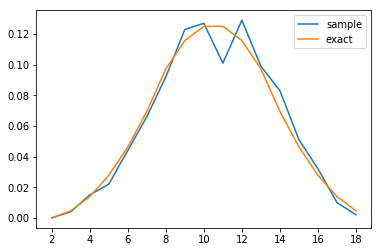

In [37]:
import thinkbayes
import numpy as np
import matplotlib.pyplot as plt

class Die(thinkbayes.Pmf):
    def __init__(self, sides):
        thinkbayes.Pmf.__init__(self)
        for x in range(1, sides+1):
            self.Set(x, 1)
        self.Normalize()
        
d6 = Die(6)

## Simulating

dice = [d6] * 3
three = thinkbayes.SampleSum(dice, 1000)

def RandomSum(dists):
    total = sum(dist.Random() for dist in dists)
    return total

def SampleSum(dists, n):
    pmf = MakePmfFromList(RandomSum(dists) for i in range(n))
    return pmf

## Enumerating

def __add__(self, other):
    pmf = Pmf()
    for v1, p1 in self.Items():
        for v2, p2 in other.Items():
            pmf.Incr(v1+v2, p1*p2)
    return pmf

## method to enumerate all pairs of values and compute sum and probability of each pair
## when + is used, this method is invoked
## Note: assumes selections from each Pmf are independent

three_exact = d6 + d6 + d6

plt.plot(np.array([(x, three.Prob(x)) for x in range(2,19)])[:,0], np.array([(x, three.Prob(x)) for x in range(2,19)])[:,1], label='sample')
plt.plot(np.array([(x, three_exact.Prob(x)) for x in range(2,19)])[:,0], np.array([(x, three_exact.Prob(x)) for x in range(2,19)])[:,1], label='exact')
plt.legend()
plt.show()

## Maxima

What if we want to know the distribution of a maximum attribute? We can either use simulation or enumeration again, or instead use exponentiation where we convert a pmf to a cdf and then use an efficient algorithm to find the distribution of the maximum.



In [ ]:
def RandomMax(dists):
    total = max(dist.Random() for dist in dists)
    return total

def SampleMax(dists, n):
    pmf = MakePmfFromList(RandomMax(dists) for i in range(n))
    
def PmfMax(pmf1, pmf2):
    res = thinkbayes.Pmf()
    for v1, p1 in pmf1.Items():
        for v2, p2 in pmf2.Items():
            res.Incr(max(v1, v2), p1*p2)
    return res



Simulation and enumeration are both inefficient, so we can try converting Pmf to Cdf.

CDF(x) = p(X <= x)

X is a random variable that represents a value randomly chosen from the distribution. CDF(5) is probability that a value from distribution is less than or equal to 5.

If we draw X from CDF1 and Y from CDF2, then compute Z=max(X,Y), what is chance Z <= 5? This happens when both X and Y are <= 5.

If selections X and Y are independent then:

CDF3(5) = CDF1(5)CDF2(5)

CDF3 is the distribution of Z. We can generalise for any value (not just 5) using z:

CDF3(z) = CDF1(z)CDF2(z)

If we are drawing k values from the same distribution we can simplify to:

CDFk(z) = CDF1(z)^k

Therefore, to find the distribution of the max of k values, we enumerate the probabilities in the Cdf and raise them to the power of k.

Runtime is proportional to number of items in the Cdf, m, rather than m^2*k as in the case of the previous approach.

Doing this from a Pmf requires a conversion to Cdf, so the runtime is mlogm.





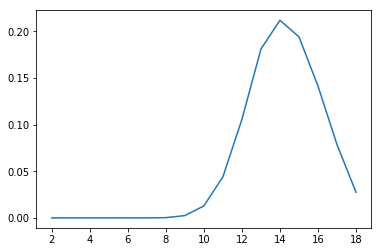

In [41]:
# class Cdf

def Max(self, k):
    cdf = self.Copy()
    cdf.ps = [p**k for p in cdf.ps]
    return cdf

best_attr_cdf = three_exact.Max(6)
best_attr_pmf = best_attr_cdf.MakePmf()

plt.plot(np.array([(x, best_attr_pmf.Prob(x)) for x in range(2,19)])[:,0], np.array([(x, best_attr_pmf.Prob(x)) for x in range(2,19)])[:,1])
plt.show()

## Mixtures

Imagine we randomly select a die from a box and roll it, what would the distribution of the outcome be?

5 x 4-sided
4 x 6-sided
3 x 8-sided
2 x 12-sided
1 x 20-sided

If we knew the die, it would be easy (n sided die gives a uniform dist from 1 to n).

Without knowing, the distribution is a mixture of uniform distributions with different bounds.

We could simulate or we could get an exact solution by iterating through the Pmfs.

This can be done for a simple 2 dice example or the full problem.

For the 2 dice example, the first loop enumerates the dice and the second loop enumerates the outcomes and their probabilities. 

Pmf.Incr() adds up the contributions from the two distributions.

For the full problem, we don't assume the dice are equally likely so we weight the outcomes.

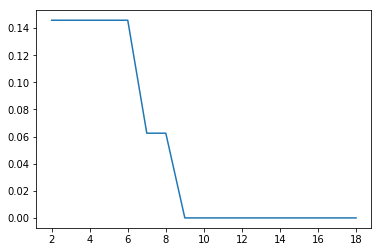

In [43]:
d6 = Die(6)
d8 = Die(8)

mix = thinkbayes.Pmf()
for die in [d6, d8]:
    for outcome, prob in die.Items():
        mix.Incr(outcome, prob)
mix.Normalize()

plt.plot(np.array([(x, mix.Prob(x)) for x in range(2,19)])[:,0], np.array([(x, mix.Prob(x)) for x in range(2,19)])[:,1])
plt.show()

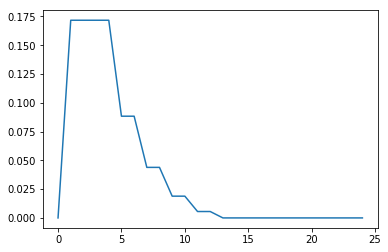

In [47]:
pmf_dice = thinkbayes.Pmf()
pmf_dice.Set(Die(4), 5)
pmf_dice.Set(Die(6), 4)
pmf_dice.Set(Die(8), 3)
pmf_dice.Set(Die(10), 2)
pmf_dice.Set(Die(12), 1)

mix = thinkbayes.Pmf()
for die, weight in pmf_dice.Items():
    for outcome, prob in die.Items():
        mix.Incr(outcome, weight*prob)
mix.Normalize()

plt.plot(np.array([(x, mix.Prob(x)) for x in range(0,25)])[:,0], np.array([(x, mix.Prob(x)) for x in range(0,25)])[:,1])
plt.show()